In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import division
import numpy as np
from IPython.core.display import HTML
from deltasigma import *

Audio demo of mod1 and mod2 - demo #4
=====================================

Demonstration of the first and second order modulators, as in `dsdemo4.m` in the **MATLAB Delta Sigma Toolbox**, albeit this demo employs its Python port **`deltasigma`**.

Port written by G. Venturini. First version Jan 1st, 2014. *Happy new year!!*

##Introduction

 * The user selects:
    * A modulator. It may be the simple `mod1` or `mod2`, or a user specified modulator.
    * The source (sine, ramp or file).
    * The $\mathrm{sinc}^n$ filter order $n$ and decimation factor.
 * The output signal and quantization error are evaluated.
 * The signals are passed through the decimation filter.

Input, output and quantization error are compared in terms of time evolution, spectra and played out aloud.

#### Options and utility functions
You may skip to the following section

In [3]:
plotsize = (20, 4) #The plot size in inches. Reduce for low res/small screens

In [4]:
# An in-browser HTML5 audio player
# Notice there is an audio player in the dev branch of iPython,
# it is unlikely that as of today Jan 1st, 2014 many people have access to it
# for that reason, the following function is used instead.
# It is originally from the notebook 'the sound of Hydrogen' by 'filmor', with small modifications.
# http://nbviewer.ipython.org/url/gist.github.com/filmor/c7ae1a867fc9058ffcd4/raw/91ce69c1400540ed39f68bd92234abfb1dc2ae70/tone-generator.ipynb
from io import BytesIO
import base64, struct

def wavPlayer(data, rate, scale=False, autoplay=False):
    """This method will display html 5 player for compatible browser with 
    embedded base64-encoded WAV audio data.

    Parameters :
    ------------
    data : 1d np.ndarray containing the audio data to be played
    rate : the data rate in Hz
    scale : if set to True, the audio signal is amplified to cover the full scale.
    """
    if np.max(abs(data)) > 1 or scale:
        data = data/np.max(abs(data))
    data = (2**13*data).astype(np.int16)
    
    buffer = BytesIO()
    buffer.write(b'RIFF')
    buffer.write(b'\x00\x00\x00\x00')
    buffer.write(b'WAVE')
    
    buffer.write(b'fmt ')
    if data.ndim == 1:
        noc = 1
    else:
        noc = data.shape[1]
    
    bits = data.dtype.itemsize * 8
    sbytes = rate*(bits // 8)*noc
    ba = noc * (bits // 8)
    buffer.write(struct.pack('<ihHIIHH', 16, 1, noc, rate, sbytes, ba, bits))

    # data chunk
    buffer.write(b'data')
    buffer.write(struct.pack('<i', data.nbytes))

    if data.dtype.byteorder == '>' or (data.dtype.byteorder == '=' and sys.byteorder == 'big'):
        data = data.byteswap()

    buffer.write(data.astype(np.int16).tostring())

    # Determine file size and place it in correct position at start of the file.
    size = buffer.tell()
    buffer.seek(4)
    buffer.write(struct.pack('<i', size-8))
    
    val = buffer.getvalue()
    autoplay = " autoplay=\"autoplay\""*autoplay + ""
    
    src = """<audio controls="controls" style="width:600px"{autoplay}>
      <source controls src="data:audio/wav;base64,{base64}" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>""".format(base64=base64.b64encode(val).decode("ascii"), autoplay=autoplay)
    display(HTML(src))

## Parameters

### Source type
Set the `SourceType` flag, which has the following meaning:

* `0`: sine wave, see below for amplitude and frequency values.
* `1`: ramp from -.7 to +.7.
* `2`: audio file: a 9 seconds long recording of a tenor sax playing. Please make sure you download and save the file `sax.wav.b64` first, as explained below.

In [5]:
SourceType = 0 # change the SourceType

If you set `SourceType = 0` above, here you can specify the amplitude and frequency of the sine wave.

Otherwise, the following values are ignored.

In [6]:
SineAmp = .4
SineFreq = .5e3

If you set `SourceType = 1` (ramp), there is nothing you need to do.

if you set `SourceType = 2` (file), make sure you download the file `sax.wav.b64` included with this notebook and save it to the current working directory.

### Modulator order
Select a modulator order equal to `1` to have the `mod1` structure, modulator order equal to 2 provides `mod2`.

**Note:** two convenience functions `mod1()` and `mod2()` are available to quickly access NTF, STF and ABCD matrix for `mod1` and `mod2`.

Modify the following code to employ your modulator of choice!

In [7]:
mod_order = 2
if not mod_order in (1, 2):
    raise ValueError('Please choose an order equal to either 1 or 2')
ABCD_mod1 = np.array([[1., 1., -1.], [1., 0., 0.]])
ABCD_mod2 = np.array([[1., 0., 1., -1.], [1., 1., 1., -2.], [0., 1., 0., 0.]])
ABCD = ABCD_mod1 if mod_order == 1 else ABCD_mod2
print "Delta sigma modulator ABCD matrix:"
print ABCD

Delta sigma modulator ABCD matrix:
[[ 1.  0.  1. -1.]
 [ 1.  1.  1. -2.]
 [ 0.  1.  0.  0.]]


### $\mathrm{sinc}^n$ decimation filter: parameters

In [8]:
SincOrder = 2 # SincOrder
DecFact = 32 # 32 DecFact

### Misc. options

In [9]:
T = 2 # Input signal duration in seconds.
FsOut = 8192 # set to ensure compatibility.
Fs = FsOut*DecFact #Fs

## Simulation
###Setup the input signal

In [10]:
N = int(np.round(T*Fs))
if SourceType == 0:
    SineAmp = max(min(SineAmp, 1), 0) # 0 <= SineAmp <= 1
    if SineFreq >= FsOut/2:
        raise ValueError('Anything above FsOut/2 (%g) will be inaudible.' % FsOut/2)
    print "Generating a sine wave:"
    print " * at freq. %g Hz, " % SineFreq
    print " * with norm. amplitude %g," % SineAmp
    print " * sampled at %g Hz," % Fs
    print " * total length %g s (%d #samples)." % (T, N)
    u = SineAmp*np.sin(2*np.pi*SineFreq/Fs*np.arange(N))*ds_hann(N)
    u0 = u[::DecFact]
elif SourceType == 1:
    u = np.linspace(-0.7, 0.7, N)
    u0 = u[::DecFact]
    print "Generating a ramp:"
    print " * from -.7 to +.7, "
    print " * sampled at %g Hz," % Fs
    print " * total length %g s (%d #samples)." % (T, N)
elif SourceType == 2:
    from scipy.interpolate import interp1d as interp
    filename = 'sax.wav'
    T = 9
    try:
        from scipy.io import wavfile  
    except ImportError:
        print "Error: Reading audio files requires scipy > v 0.12.0"
    try:
        fpin = open(filename + '.b64', 'r')
        b64data = fpin.read()
        fpin.close()
        fpout = open(filename, 'wb')
        fpout.write(base64.b64decode(b64data))
        fpout.close()
        sr, filedata = wavfile.read(filename)
    except IOError:
        print "Wav file %s not found." % filename
    if len(filedata.shape) == 2:
        filedata = np.average(filedata, axis=1)
    T = min(T, filedata.shape[0]/sr)
    N = int(np.round(T*Fs))
    filedata = filedata[:int(np.round(T*sr)+1)]
    if max(abs(filedata)) > 1:
        filedata = filedata/max(abs(filedata))
    filets = np.arange(filedata.shape[0])/sr
    ts = (np.arange(N)/Fs)
    u0 = interp(filets, filedata)(ts[::DecFact])
    u = interp(filets, filedata)(ts)
    print "Decoded the file %s.b64 and loaded its data." % filename
    print "Input data available:"
    print " * sampled at %g Hz," % Fs
    print " * total length %g s (%d #samples)." % (T, N)
    print " * normalized (only if amp > 1)"

Generating a sine wave:
 * at freq. 500 Hz, 
 * with norm. amplitude 0.4,
 * sampled at 262144 Hz,
 * total length 2 s (524288 #samples).


## Inspect the input signal
### Plot: time domain

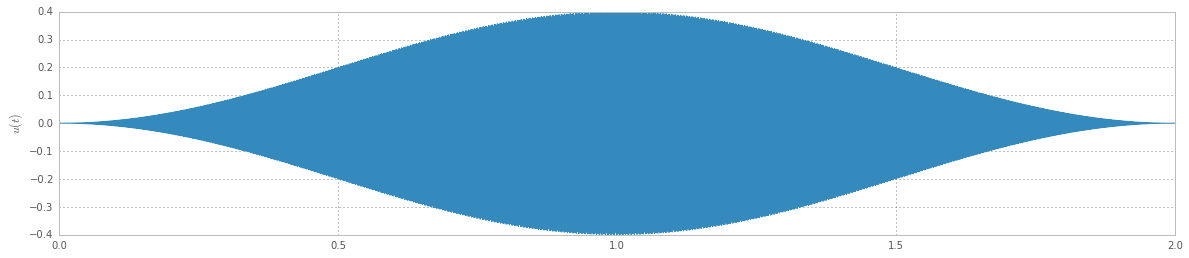

In [11]:
plot(np.arange(N)[::DecFact]/Fs, u0)
figureMagic(size=(20,4))
ylabel('$u(t)$');

### Plot: frequency domain

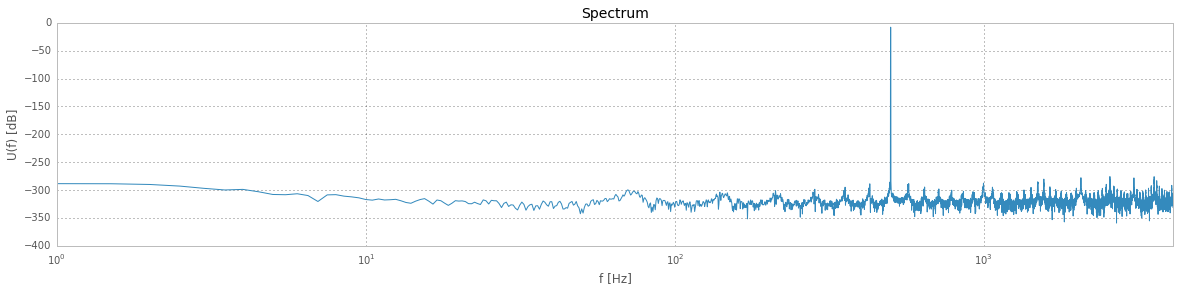

In [12]:
if SourceType == 0 or SourceType == 2:
    N = max(u0.shape)
    if SourceType == 0:
        U = np.fft.fft(u0)/(N/4)
    else:
        U = np.fft.fft(u0 * ds_hann(N))/(N/4)
    f = np.linspace(0, FsOut, N + 1)
    f = f[:N/2 + 1]
    semilogx(f, dbv(U[:N/2 + 1]))
xlabel('f [Hz]')
ylabel('U(f) [dB]')
figureMagic(xRange=[1, max(f)], size=plotsize, name='Spectrum')

### Play the input signal

Click on the Play button to listen to the input signal.

*Requires a HTML5-capable browser such as recent version of Chrome, Firefox or IE.*

In [13]:
# Show a Html 5 audio player
wavPlayer(data=u0, rate=FsOut)

## Simulate!
The simulation is run calling `simulateDSM()`.

In [14]:
v, junk1, junk2, y = simulateDSM(u, ABCD)
del junk1, junk2
q = v - y # quantization error

## Inspect the output

### Plot: time domain

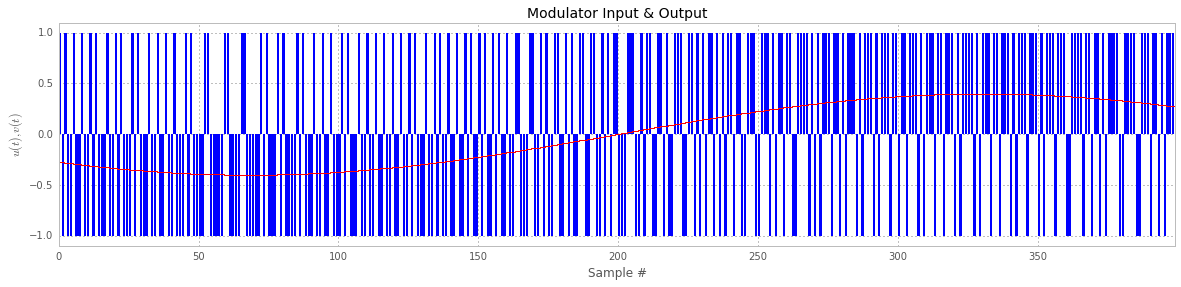

In [15]:
N = max(v.shape)
nPlot = 400
if N > nPlot:
    n = np.arange(int(np.floor(N/2 - nPlot/2)), int(np.floor(N/2 + nPlot/2)))
else:
    n = np.arange(N)
n = n.astype(np.int32)
hold(True)
t = np.arange(max(n.shape))
step(t, u[n], 'r')
bar(t, v[n], color='b', linewidth=0)
ylabel('$u(t), v(t)$')
xlabel('Sample #')
axis([0, max(n)-min(n), -1.1, 1.1])
figureMagic(size=(20, 4), name='Modulator Input & Output')

### Plot: frequency domain

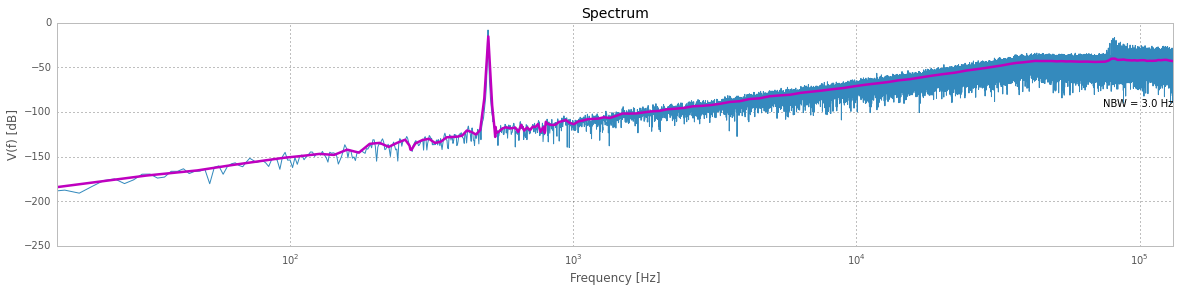

In [16]:
N = max(v.shape)
Nfft = min(N, 16*8192)
n = np.arange((N - Nfft)/2, (N + Nfft)/2).astype(np.int32)
V = np.fft.fft(v[n] * ds_hann(Nfft)) / (Nfft / 4)
if SourceType == 1:
    inBin = np.round(SineFreq/Fs*Nfft)
else:
    inBin = np.ceil(Nfft/1000)
hold(True)
ylabel('V(f) [dB]')
xlabel('Frequency [Hz]')
semilogx(np.arange(max(V.shape))/max(V.shape)*Fs, dbv(V))
f, Vp = logsmooth(V, inBin)
semilogx(f*Fs, Vp, 'm', linewidth=2.5)
xlim([f[0]*Fs, Fs/2])
msg = 'NBW = %.1f Hz ' % (Fs*1.5/Nfft)
text(Fs/2, -90, msg, horizontalalignment='right', verticalalignment='center')
figureMagic(size=plotsize, name='Spectrum')

### Decimate; Comparison of output signal and input signal

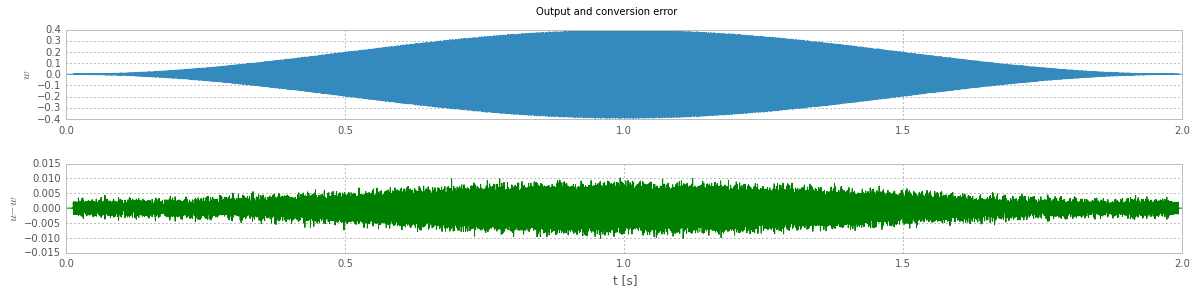

In [17]:
w = sinc_decimate(v, SincOrder, DecFact)
filtered_q = sinc_decimate(q, SincOrder, DecFact)
N = max(w.shape)
t = np.arange(N)/FsOut
subplot(211)
plot(t, w)
ylabel('$w$')
figureMagic(size=(20, 4))
subplot(212)
plot(t, u0 - w, 'g')
ylabel('$u-w$')
xlabel('t [s]')
figureMagic(size=(20, 4))
suptitle('Output and conversion error');

### Play the output signal

Click on the Play button to listen to the output signal `w`.

In [18]:
wavPlayer(data=w, rate=FsOut)

### Play the quantization error (filtered)

Click on the Play button to listen to the quantization error `filtered_q`.

In [19]:
wavPlayer(data=filtered_q, rate=FsOut, scale=True)

###Play the difference in the signal before and after A/D conversion

In [20]:
wavPlayer(data=u0-w, rate=FsOut, scale=True)

### Final comparison of the spectra of the three signals

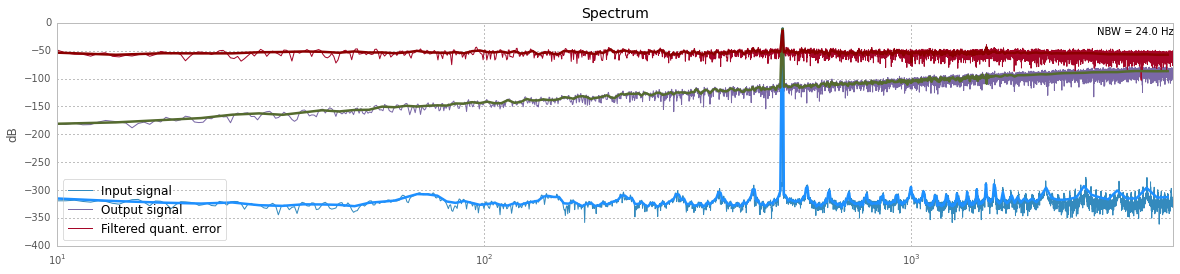

In [21]:
N = max(filtered_q.shape)
Nfft = min(N, 16*8192)
n = np.arange((N - Nfft)/2, (N + Nfft)/2).astype(np.int32)
E = np.fft.fft(filtered_q[n] * ds_hann(Nfft)) / (Nfft / 4)
W = np.fft.fft(w[n] * ds_hann(Nfft)) / (Nfft / 4)
U0 = np.fft.fft(u0[n] * ds_hann(Nfft)) / (Nfft / 4)
if SourceType == 0:
    inBin = np.round(SineFreq*Nfft)/FsOut
else:
    inBin = np.ceil(Nfft/1000)
hold(True)
ylabel('dB')
semilogx(np.arange(Nfft)/Nfft*FsOut, dbv(U0), label='Input signal')
semilogx(np.arange(Nfft)/Nfft*FsOut, dbv(W), label='Output signal')
semilogx(np.arange(Nfft)/Nfft*FsOut, dbv(E), label='Filtered quant. error')
f, U0p = logsmooth(U0, inBin)
semilogx(f*FsOut, U0p, '#1E90FF', linewidth=2.5)
f, Wp = logsmooth(W, inBin)
semilogx(f*FsOut, Wp, '#556B2F', linewidth=2.5)
f, Ep = logsmooth(E, inBin)
semilogx(f*FsOut, Ep, '#8B0000', linewidth=2.5)
xlim([10, FsOut/2])
msg = 'NBW = %.1f Hz ' % (Fs*1.5/Nfft)
text(FsOut/2, -6, msg, horizontalalignment='right', verticalalignment='top')
figureMagic(size=plotsize, name='Spectrum')
legend(loc=3);

## Conclusions

We briefly demonstrated the use of two modulators to perform A/D conversion of audio signals. 

Feel free to go through this notebook, change the parameters and resimulate!

### System version information

In [22]:
#%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%reload_ext version_information

%version_information numpy, scipy, matplotlib, deltasigma

Software versions
Python 2.7.10 64bit [GCC 4.2.1 (Apple Inc. build 5577)]
IPython 3.1.0
OS Darwin 14.3.0 x86_64 i386 64bit
numpy 1.9.2
scipy 0.15.1
matplotlib 1.4.3
deltasigma 0.2.0
Tue Jun 09 19:24:05 2015 CEST